In [22]:
import wave
import scipy
import csv
import librosa
import numpy as np
import matplotlib.pyplot as plt
from dtw import dtw
from IPython.display import Audio

from shapedtw.shapedtw import shape_dtw
from shapedtw.shapeDescriptors import DerivativeShapeDescriptor
from shapedtw.dtwPlot import dtwPlot
from speech_recognition import get_all_distance_for_one_user, get_metrics, load_csv

# Experiment 2 - Speech Recognition

The DTW being used a lot in the field of speech recognition, as a second experiment, we would like to compare the performance of DTW and shapeDTW for such a task.

We work with the Surrey Audio-Visual Expressed Emotion (SAVEE) database. It was created as a foundational step for the development of an automatic emotion recognition system. This database comprises recordings from four native English male speakers (identified as DC, JE, JK, KL), encompassing seven distinct emotions and totaling 480 British English utterances.
The data can be found in the _data/savee_ folder.

Let's first visualize and hear an example of audio signal from the database.

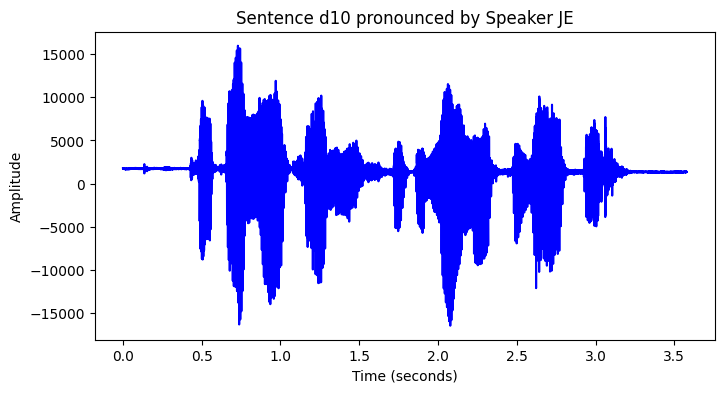

In [23]:
# Sentence d10 pronounced by speaker JE
wav_file_path = 'data/savee/JE_d10.wav'

with wave.open(wav_file_path, 'rb') as wav_file:
    framerate = wav_file.getframerate()
    n_frames = wav_file.getnframes()

    # Read the audio data
    signal = wav_file.readframes(n_frames)
    signal = np.frombuffer(signal, dtype=np.int16)

# Calculate the time axis
time = np.linspace(0, len(signal) / framerate, num=len(signal))

# Plot the signal
plt.figure(figsize=(8, 4))
plt.plot(time, signal, color='blue')
plt.title(f"Sentence d10 pronounced by Speaker JE") 
plt.xlabel('Time (seconds)')
plt.ylabel('Amplitude')
plt.show()

sample_rate, audio_data = scipy.io.wavfile.read(wav_file_path)
Audio(data=audio_data, rate=sample_rate)

### Example of Audio Comparison Using MFCC and DTW

First, we want to compare audio signals thanks to DTW. 

The audio comparison process consists of two distinct stages. First, the MFCC (Mel-Frequency Cepstral Coefficient) calculation part which extracts features from the audio sample, providing information about the rate of change in spectral bands. This step is crucial as it helps in identifying the content of the audio sample and facilitates a unique identification. The MFCCs of an audio signal are a small set of features (usually about 10–20) which describe the overall shape of the spectral envelope. We use the librosa library to extract the MFCCs.

You can see below an example of comparison of 2 sentences thanks to the DTW. We plot the alignment path.

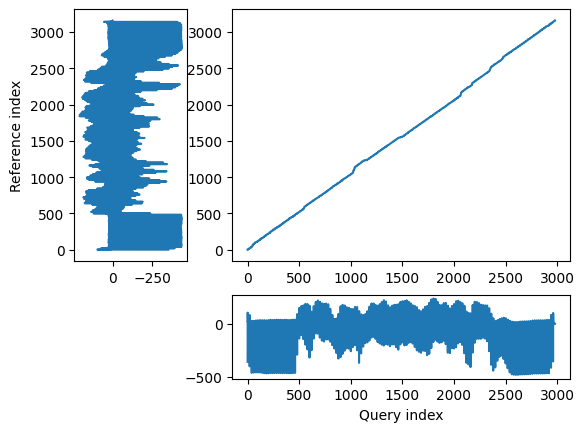

The DTW distance between the 2 signals is 8.49.


In [24]:
# DTW for Speech Recognition

# Example with 2 speakers DC and KL pronouncing the same sentence
audio_file1 = 'data/savee/DC_a02.wav'
audio_file2 = 'data/savee/JK_a02.wav'

# Load audio files
audio1, sr1 = librosa.load(audio_file1)
audio2, sr2 = librosa.load(audio_file2)

# Extract MFCC features
mfccs1 = librosa.feature.mfcc(y=audio1, sr=sr1).T
mfccs2 = librosa.feature.mfcc(y=audio2, sr=sr2).T

# Flatten MFCC matrices
mfccs1_flat = mfccs1.flatten()
mfccs2_flat = mfccs2.flatten()

# Calculate DTW distance
alignment = dtw(mfccs1_flat, mfccs2_flat, keep_internals=True)
distance = alignment.normalizedDistance

# Plot the alignment path
alignment.plot(type="threeway", offset=-5)

# plt.title('DTW Alignment Path')
plt.show()

print(f"The DTW distance between the 2 signals is {np.round(distance,2)}.")

Then, we can visualize the MFCCs coefficients from a sentence.

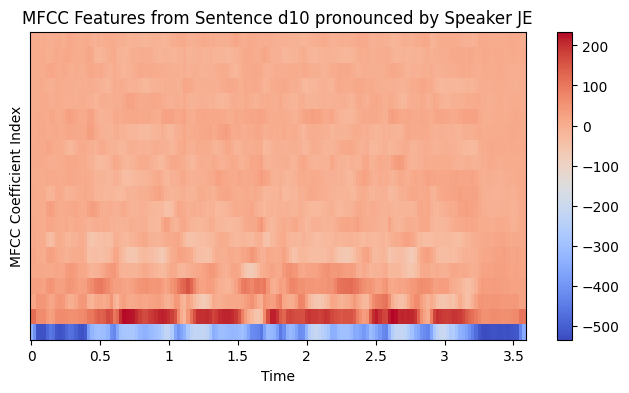

In [25]:
# Visualize MFCC

audio_file = 'data/savee/JE_d10.wav'

# Load audio file
audio, sr = librosa.load(audio_file)

# Extract MFCC features
mfccs = librosa.feature.mfcc(y=audio, sr=sr)

# Plot MFCC features
plt.figure(figsize=(8, 4))
librosa.display.specshow(mfccs, x_axis='time')
plt.colorbar()
plt.title('MFCC Features from Sentence d10 pronounced by Speaker JE')
plt.xlabel('Time')
plt.ylabel('MFCC Coefficient Index')
plt.show()

How to read this MFCC plot?
- X-axis (horizontal): Time. This axis shows the progression of time in the audio signal.
- Y-axis (vertical): MFCC coefficients. Each point on the Y-axis represents the magnitude of a particular MFCC at a specific point in time.
- MFCC Coefficients: The MFCCs are usually represented by a set of coefficients, each capturing different aspects of the audio signal's frequency characteristics. Typically, the first few coefficients (e.g., 13) are the most informative and commonly used.
- Color Intensity: The color or intensity of the plot may represent the magnitude or amplitude of the corresponding MFCC coefficient. Darker regions usually indicate higher amplitude values.
- Feature Extraction: MFCCs are extracted by taking the Fourier Transform of short overlapping frames of the audio signal and then applying a filterbank that mimics the human ear's sensitivity to different frequencies. The resulting coefficients capture the spectral content of the audio signal in a way that is more suitable for certain types of analysis, such as pattern recognition.
- Vertical Patterns: Patterns along the Y-axis can indicate specific characteristics of the audio signal at different points in time. For example, certain patterns might represent the presence of specific phonemes or other sound events.
- Horizontal Patterns: Patterns along the X-axis may indicate how certain frequency characteristics evolve over time. This can be useful for tasks like detecting changes in speech or identifying specific segments in audio.
- Dynamic Changes: Look for dynamic changes in the MFCC plot. Sudden spikes or drops might indicate abrupt changes in the audio signal, while gradual changes might represent more continuous variations.

### Example of Audio Comparison Using MFCC and shapeDTW

The shapeDTW distance between the 2 signals is 19.66.


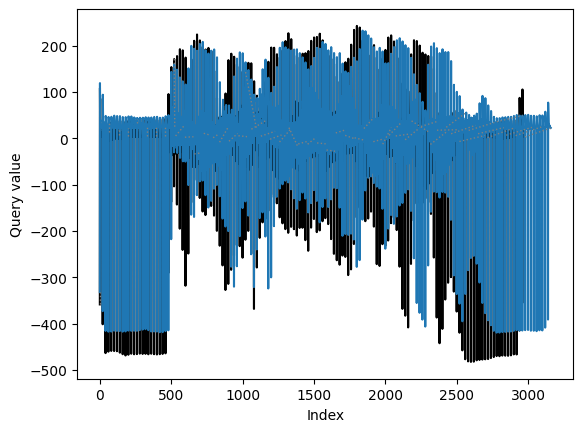

In [26]:
# Derivative Shape Descriptor
derivative_descriptor = DerivativeShapeDescriptor()

shape_dtw_results = shape_dtw(
    x = mfccs1_flat, # we use the same signals as before
    y = mfccs2_flat,
    subsequence_width = 20,
    step_pattern = "symmetric2",
    shape_descriptor = derivative_descriptor
)

# Distance between shape descriptors of time series, not time series itself
print(f"The shapeDTW distance between the 2 signals is {np.round(shape_dtw_results.normalized_distance,2)}.")
dtwPlot(shape_dtw_results, plot_type="twoway", yoffset = 20)

### Audio comparison of each sentence for each speaker with DTW and shapeDTW

The aim of this experiment is to perform audio comparison thanks to DTW and shapeDTW. We want to compare a sentence spoken by one actor with all the sentences spoken by another person, then extract the most similar sentence using DTW or shapeDTW. This comparison is carried out for all sentences and for all actors, in order to obtain a rate of correctly and incorrectly recognized sentences. We expect a better performance of the shapeDTW thanks to its ability to take local neighborhood information into account.

We use the function from the _speech_recognition.py_ file in the part. Since it was quite long to compare each sentence for each speaker, we saved the result in the _data/results_ folder.

If you wanted to reproduce our experiment, you would have to run the next cell (it takes several hours). Otherwise, you can load our results in the second next cell. 

In [ ]:
for speaker in ['DC', 'JE', 'JK']:
    for distance in ['dtw', 'shapedtw']:
        print(f"Speaker is {speaker} and Distance is {distance}")
        res_list = []
        res_list = get_all_distance_for_one_user(speaker, distance)
        
        # csv_file = f"data/results/{speaker}_{distance}.csv"
        csv_file = f"data/results/{speaker}_{distance}_2.csv" # to not overwrite the previous results
        
        with open(csv_file, 'w', newline='') as csvfile:
            writer = csv.writer(csvfile)
            writer.writerow(['Data'])
            for item in res_list:
                writer.writerow([item])

        print(f'CSV file "{csv_file}" has been created.')

In [33]:
for speaker in ['DC', 'JE', 'JK']:
    for distance in ['dtw', 'shapedtw']:
        print(f"When the original sentence is pronounced by {speaker} and the distance used to compare sentences is {distance}:")
        print(get_metrics(speaker, load_csv(f"data/results/{speaker}_{distance}.csv")))

When the original sentence is pronounced by DC and the distance used to compare sentences is dtw:
{'JE compared to DC': {'Correct matches': 70, 'Wrong matches': 50}, 'JK compared to DC': {'Correct matches': 73, 'Wrong matches': 47}, 'DC compared to DC': {'Correct matches': 0, 'Wrong matches': 0}}
When the original sentence is pronounced by DC and the distance used to compare sentences is shapedtw:
{'JE compared to DC': {'Correct matches': 73, 'Wrong matches': 47}, 'JK compared to DC': {'Correct matches': 82, 'Wrong matches': 38}, 'DC compared to DC': {'Correct matches': 0, 'Wrong matches': 0}}
When the original sentence is pronounced by JE and the distance used to compare sentences is dtw:
{'JE compared to JE': {'Correct matches': 0, 'Wrong matches': 0}, 'JK compared to JE': {'Correct matches': 60, 'Wrong matches': 59}, 'DC compared to JE': {'Correct matches': 69, 'Wrong matches': 50}}
When the original sentence is pronounced by JE and the distance used to compare sentences is shapedtw

We notice a higher success rate when using shapeDTW, i.e. a higher number of well-matched sentences. For instance, the success rate when the original speaker is JE goes from 53.7\% with DTW to 61.7\% with shapeDTW.